# Sea ice area anomaly time series using OSISAF data

In [8]:
#input data

# climatology range
clst = 1979 ;clen = 2008

#input path
src  = 'NSIDC'
diri = '/g/data/gv90/wrh581/'+src+'/monthly_sic/'
iNam = 'cdr_seaice_conc_monthly'
#iNam = 'ice_conc'

#output path
diro = '/g/data/jk72/wrh581/Obs-seaice-analysis/plots/'
filo = src+'_totalSIA_tplot.png'

In [3]:
#import libraries 
import xarray as xr
import cf_xarray as cf
import matplotlib.pyplot as plt
import numpy as np

#### read data

In [24]:

# cmd = 'ls '+diri+'*.nc'#ice_conc_sh_ease2-250_*.nc'
if src == 'NSIDC':
    cmd = 'ls '+diri+'sic_pss25_*.nc'

fpath = !$cmd


data = xr.open_mfdataset(fpath, chunks = -1, parallel=True).compute()
data



/jobfs/154573651.gadi-pbs/ipykernel_3278668/2561236108.py:8: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  data = xr.open_mfdataset(fpath, chunks = -1, parallel=True).compute()


<xarray.Dataset> Size: 531MB
Dimensions:                          (time: 562, y: 332, x: 316)
Coordinates:
  * time                             (time) datetime64[ns] 4kB 1978-11-01 ......
  * y                                (y) float64 3kB 4.338e+06 ... -3.938e+06
  * x                                (x) float64 3kB -3.938e+06 ... 3.938e+06
Data variables:
    cdr_seaice_conc_monthly          (time, y, x) float32 236MB 0.0 0.0 ... 0.0
    cdr_seaice_conc_monthly_stdev    (time, y, x) float32 236MB 0.0 0.0 ... 0.0
    cdr_seaice_conc_monthly_qa_flag  (time, y, x) uint8 59MB 16 16 16 ... 80 80
    crs                              (time) int32 2kB -2147483647 ... -214748...
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2025-04-01T22:21:44Z
    time_coverage_start:       1978-11-01T00:00:00Z
    time_coverage_end:         2024-12-31T23:59:59Z
    time_coverage_resolution:  P1M
    time_coverage_duration:    P554M
    ...                        ...
    geospatial_lat_min:        -90.0
    geospatial_lat_max:        -39.23089
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

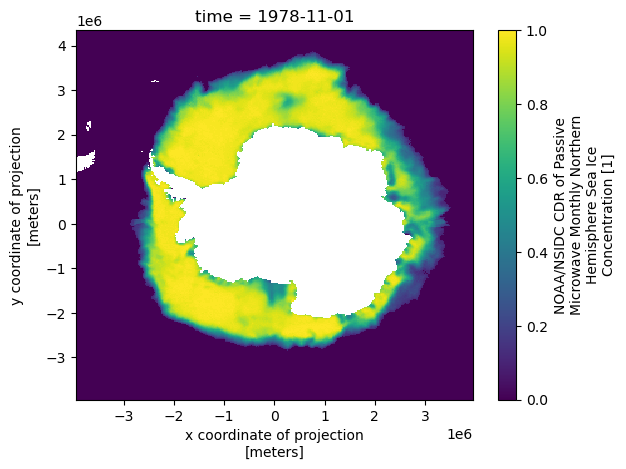

In [9]:
data[iNam][0,:,:].plot()

#### Calc SIA

In [25]:
# grid is a 25km equal area, units are percent


if src == 'OSISAF':
    A = 25**2. * 1.e-6    #will convert to million km
    data[iNam] = data[iNam] * 0.01 #convert from % to fraction
elif src == 'NSIDC':
    A = 25**2. * 1.e-6  

#SIA
data[iNam] = data[iNam].where(data[iNam] > 0.15)
SIA = (data[iNam] * A).sum((data.cf['X'].name, data.cf['Y'].name))


#SIE
data[iNam].values = np.where(np.isnan(data[iNam].values),0., 1.)
SIE =  (data[iNam] * A ).sum((data.cf['X'].name, data.cf['Y'].name))

if src == 'NSIDC':
    SIA.loc[{'time' : slice('1987-12','1988-01')}] = np.nan
    SIE.loc[{'time' : slice('1987-12','1988-01')}] = np.nan


### HACK TO READ AND CONCATENATE AMSR2 DATA

In [40]:
dir_amsr = '/g/data/gv90/wrh581/NSIDC/AMSR2/'
cmd = 'ls '+dir_amsr+'NSIDC-0803_SEAICE_AMSR2_S_2025{09,10}??_v2.0.nc'
fpath = !$cmd

amsr = xr.open_mfdataset(fpath, chunks = -1, parallel=True)
amsr = amsr.resample(time ='1ME', ).mean().compute()


#get area
amsr['ICECON'] = amsr['ICECON'].where((amsr['ICECON'] > .15) & (amsr['ICECON'] <= 1.))
amsr_SIA = (amsr['ICECON'] * A).sum((amsr.cf['X'].name, amsr.cf['Y'].name))

SIA = xr.concat([SIA, amsr_SIA], dim = 'time')


#SIE
amsr['ICECON'].values = np.where(np.isnan(amsr['ICECON'].values),0., 1.)

amsr_SIE =  (amsr['ICECON'] * A).sum((amsr.cf['X'].name, amsr.cf['Y'].name))

SIE = xr.concat([SIE, amsr_SIE], dim = 'time')




/jobfs/154573651.gadi-pbs/ipykernel_3278668/2565000169.py:5: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  amsr = xr.open_mfdataset(fpath, chunks = -1, parallel=True)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


#### plot

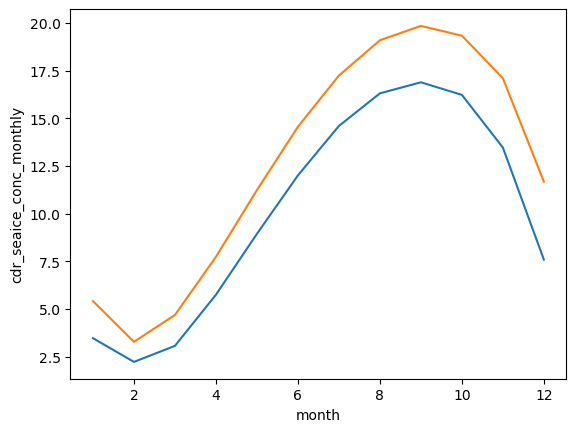

In [41]:
SIA.groupby('time.month').mean('time').plot()
SIE.groupby('time.month').mean('time').plot()


In [56]:
SIA = SIA.groupby('time.month') - SIA.sel(time = slice(str(clst),str(clen))).groupby('time.month').mean('time')

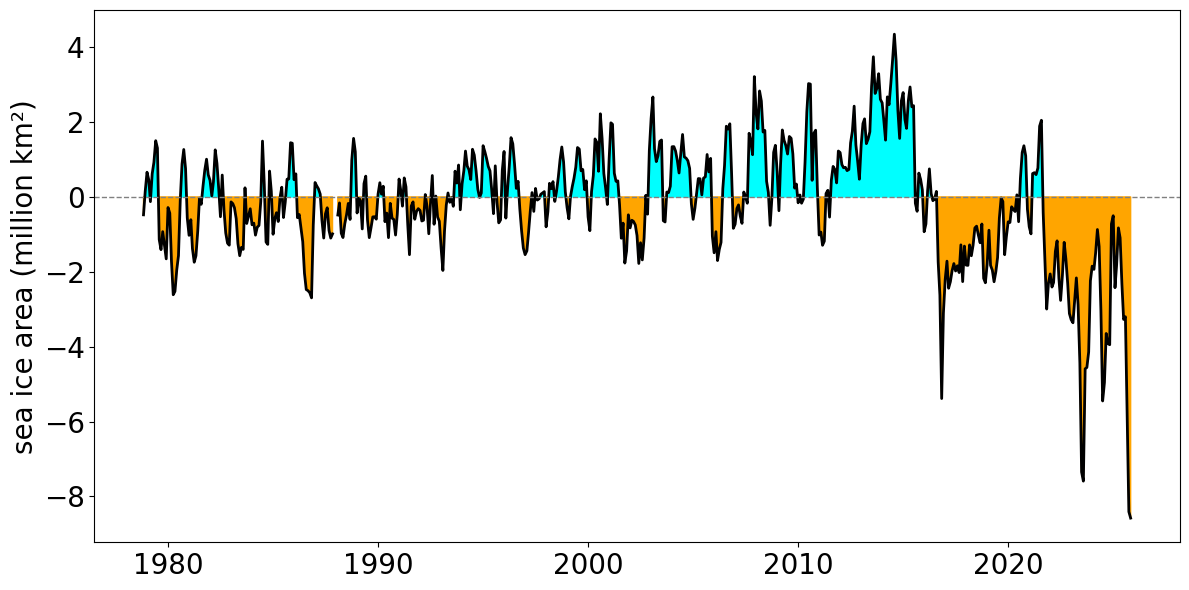

In [60]:




# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

ax.tick_params(axis='x', labelsize=20)  # Change x-axis tick label size
ax.tick_params(axis='y', labelsize=20)


# Plot the sea ice area anomalies
ax.plot(SIA.time, SIA.values, color='black', linewidth=2, label='Sea Ice Area Anomaly')

# Shade positive and negative anomalies
ref_line = 0.
ax.fill_between(SIA.time, SIA.values, ref_line, where=SIA.values > ref_line, interpolate=True, color='cyan', label='Positive Anomaly')
ax.fill_between(SIA.time, SIA.values, ref_line, where=SIA.values < ref_line, interpolate=True, color='orange', label='Negative Anomaly')

# Add reference line
ax.axhline(ref_line, color='gray', linestyle='--', linewidth=1)



# Axis labels and title
ax.set_ylabel(f"sea ice area (million km²)", fontsize = 20.)



# Save the plot
plt.tight_layout()
plt.savefig(diro+filo)
plt.show()

In [62]:
SIA.values

array([-4.77657516e-01,  1.53738065e-01,  6.60615115e-01,  4.52354750e-01,
       -1.25061490e-01,  6.18813323e-01,  9.26201443e-01,  1.50303508e+00,
        1.30663775e+00, -1.13589219e+00, -1.40759108e+00, -9.26751770e-01,
       -1.30229541e+00, -1.65383687e+00, -2.82630052e-01, -4.32892733e-01,
       -1.70919332e+00, -2.61204321e+00, -2.52163290e+00, -1.94819878e+00,
       -1.57012192e+00, -8.40538182e-02,  8.81796994e-01,  1.26787988e+00,
        7.57669923e-01, -5.57908020e-01, -1.02501593e+00, -6.07853020e-01,
       -1.38025435e+00, -1.74373710e+00, -1.56988905e+00, -9.11964883e-01,
       -3.23971118e-02, -1.96122026e-01,  2.92261343e-01,  7.10720433e-01,
        1.00841123e+00,  5.91434711e-01,  4.40471941e-01,  2.78376636e-02,
        4.07682971e-01,  1.25833057e+00,  8.98160236e-01,  2.16323970e-01,
       -5.28395356e-01,  5.84834368e-01, -3.61241354e-01, -9.63406227e-01,
       -1.23439028e+00, -1.28866806e+00, -1.32011544e-01, -1.79330236e-01,
       -2.86410615e-01, -

In [58]:
SIA = SIA.groupby('time.month')/SIA.sel(time = slice(str(clst),str(clen))).groupby('time.month').std('time')

Text(0, 0.5, 'sigma')

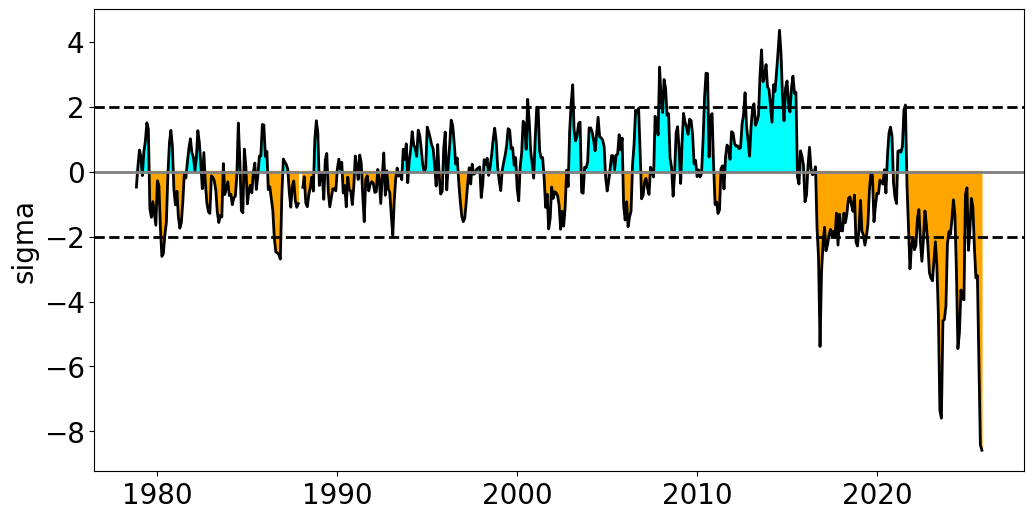

In [59]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

ax.tick_params(axis='x', labelsize=20)  # Change x-axis tick label size
ax.tick_params(axis='y', labelsize=20)


# Plot the sea ice area anomalies
ax.plot(SIA.time, SIA.values, color='black', linewidth=2, label='Sea Ice Area Anomaly')

# Shade positive and negative anomalies
ref_line = 0.
ax.fill_between(SIA.time, SIA.values, ref_line, where=SIA.values > ref_line, interpolate=True, color='cyan', label='Positive Anomaly')
ax.fill_between(SIA.time, SIA.values, ref_line, where=SIA.values < ref_line, interpolate=True, color='orange', label='Negative Anomaly')

# Add reference lines
ax.axhline(0., color='gray', linestyle='-', linewidth=2)
ax.axhline(2., color='black', linestyle='--', linewidth=2.)
ax.axhline(-2., color='black', linestyle='--', linewidth=2.)

# Axis labels and title
ax.set_ylabel(f"sigma", fontsize = 20.)

### write to file